<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/home/kris/Документы/user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'week1/files/X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'week1/files/y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [43]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.title('График зависимости доли правильных ответов на кросс-валидации от C',fontsize = 12, fontweight = 'bold')
    plt.xlabel('C', fontsize = 12)
    plt.ylabel('Доля правильных ответов', fontsize = 12)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [10]:
knn = KNeighborsClassifier(n_neighbors=100)
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy').mean()
knn.fit(X_train, y_train)
knn_valid = accuracy_score(y_valid,knn.predict(X_valid))

In [11]:
print('Доля правильных ответов на 3-кратной кросс-валидации: %f и на отложенной выборке: %f' % (knn_cv_scores, knn_valid))

Доля правильных ответов на 3-кратной кросс-валидации: 0.559337 и на отложенной выборке: 0.584025


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
with open('answers/answer4_1', 'w') as f:
    ans = str(round(knn_cv_scores, 3)) + ' ' + str(round(knn_valid, 3))
    f.write(ans)

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)
forest.fit(X_train, y_train)
oob_score = forest.oob_score_
forest_valid = accuracy_score(y_valid,forest.predict(X_valid))

In [15]:
print('Доля правильных ответов при Out-of-Bag оценке: %f и на отложенной выборке: %f' % (oob_score, forest_valid))

Доля правильных ответов при Out-of-Bag оценке: 0.719874 и на отложенной выборке: 0.732164


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [28]:
with open('answers/answer4_2', 'w') as f:
    ans = str(round(oob_score, 3)) + ' ' + str(round(forest_valid, 3))
    f.write(ans)

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [16]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [17]:
logit = LogisticRegression(random_state=17)
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy').mean()
logit.fit(X_train, y_train)
logit_valid = accuracy_score(y_valid, logit.predict(X_valid))

In [18]:
print('Доля правильных ответов на кросс-валидации: %f и на отложенной выборке: %f' % (logit_cv_scores, logit_valid))

Доля правильных ответов на кросс-валидации: 0.760619 и на отложенной выборке: 0.776724


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [19]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 2min 44s, sys: 2.68 s, total: 2min 47s
Wall time: 42.6 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None, cv=None, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=17, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [20]:
logit_mean_cv_scores1 = np.mean(list(logit_grid_searcher1.scores_.values())[0],axis=0)
print(logit_mean_cv_scores1)

[0.37421192 0.47917038 0.56228354 0.65921514 0.72678354 0.75675733
 0.76783199 0.76447869 0.76010944 0.74761187]


In [21]:
print('Лучшее значение доли правильных ответов на кросс-валидации: ',max(logit_mean_cv_scores1),'и соответствующее C: ',logit_c_values1[list(logit_mean_cv_scores1).index(max(logit_mean_cv_scores1))])

Лучшее значение доли правильных ответов на кросс-валидации:  0.7678319852015179 и соответствующее C:  1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

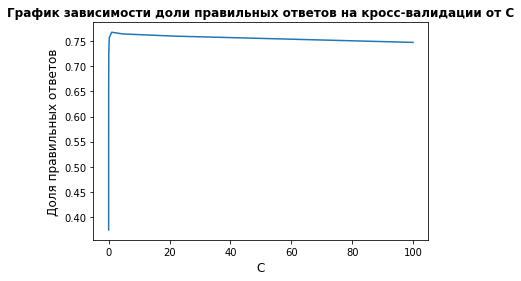

In [22]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.title('График зависимости доли правильных ответов на кросс-валидации от C',fontsize = 12, fontweight = 'bold')
plt.xlabel('C', fontsize = 12)
plt.ylabel('Доля правильных ответов', fontsize = 12)
plt.show()

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [23]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 8min 22s, sys: 6.68 s, total: 8min 28s
Wall time: 2min 8s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None, cv=None, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=17, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [24]:
logit_mean_cv_scores2 = np.mean(list(logit_grid_searcher2.scores_.values())[0],axis=0)
print(logit_mean_cv_scores2)

[0.7442595  0.76549536 0.76823875 0.76783219 0.76773062 0.76630842
 0.76610527 0.76569866 0.76498702 0.76508844 0.76417396 0.76478351
 0.76407218 0.76366568 0.76346248 0.76285288 0.76295445 0.76244653
 0.7619384  0.76203992]


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [25]:
print('Лучшее значение доли правильных ответов на кросс-валидации: ', max(logit_mean_cv_scores2),'и соответствующее C: ',logit_c_values2[list(logit_mean_cv_scores2).index(max(logit_mean_cv_scores2))])

Лучшее значение доли правильных ответов на кросс-валидации:  0.7682387473316072 и соответствующее C:  0.8263157894736842


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

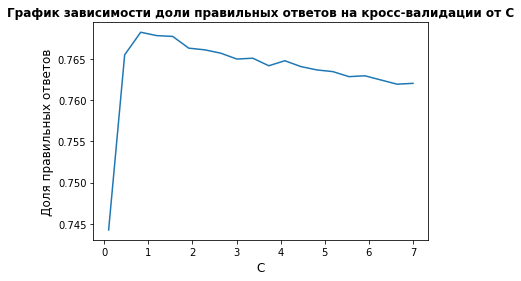

In [26]:
plt.plot(logit_c_values2, logit_mean_cv_scores2)
plt.title('График зависимости доли правильных ответов на кросс-валидации от C',fontsize = 12, fontweight = 'bold')
plt.xlabel('C', fontsize = 12)
plt.ylabel('Доля правильных ответов', fontsize = 12)
plt.show()

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [27]:
logit = LogisticRegression(C=logit_c_values2[list(logit_mean_cv_scores2).index(max(logit_mean_cv_scores2))], random_state=17)
logit.fit(X_train,y_train)
logit_valid = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))  
print('Доля правильных ответов на отложенной выборке при С=3: %f' % logit_valid)

Доля правильных ответов на отложенной выборке при С=3: 0.775065


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [35]:
with open('answers/answer4_3.txt', 'w') as f:
    ans = str(round(max(logit_mean_cv_scores2), 3)) + ' ' + str(round(logit_valid, 3))
    f.write(ans)

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [36]:
from sklearn.svm import LinearSVC

In [37]:
svm = LinearSVC(C=1, random_state=17)
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy').mean()
svm.fit(X_train, y_train)
svm_valid = svm.score(X_valid,y_valid)

In [38]:
print('Доля правильных ответов на 3-кратной кросс-валидации: %f и на отложенной выборке: %f' % (svm_cv_scores, svm_valid))

Доля правильных ответов на 3-кратной кросс-валидации: 0.750866 и на отложенной выборке: 0.776961


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [39]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 44.1 s, sys: 4 ms, total: 44.1 s
Wall time: 44.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [41]:
print('Лучшее значение доли правильных ответов на кросс-валидации: %f' % svm_grid_searcher1.best_score_)

Лучшее значение доли правильных ответов на кросс-валидации: 0.686855


In [42]:
svm_grid_searcher1.best_params_

{'C': 2222.2223000000004}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

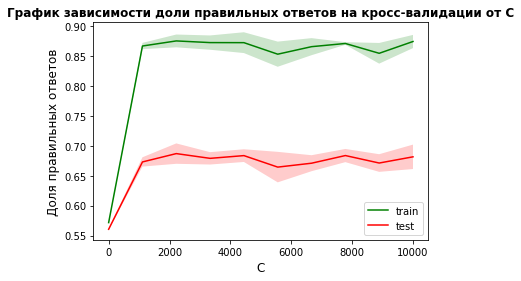

In [44]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [45]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 1min 24s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.035448...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=Non

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [46]:
print('Лучшее значение доли правильных ответов на кросс-валидации: %f' % svm_grid_searcher2.best_score_)

Лучшее значение доли правильных ответов на кросс-валидации: 0.767021


In [47]:
svm_grid_searcher2.best_params_

{'C': 0.10434482758620689}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

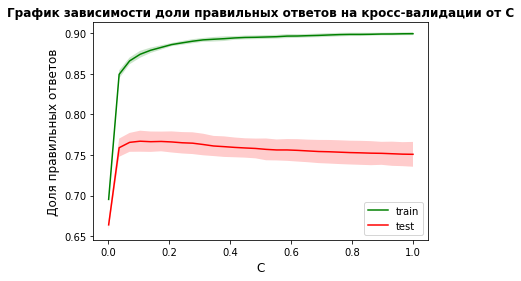

In [48]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [50]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)
svm_valid = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

In [51]:
print('Доля правильных ответов на отложенной выборке при С=0.104: %f' % svm_valid)

Доля правильных ответов на отложенной выборке при С=0.104: 0.780754


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [52]:
with open('answers/answer4_4.txt', 'w') as f:
    ans = str(round(svm_grid_searcher2.best_score_, 3)) + ' ' + str(round(svm_valid, 3))
    f.write(ans)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [53]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    with open(path_to_X_pickle, 'rb') as fp:
        X_pickle = pickle.load(fp)
    with open(path_to_y_pickle, 'rb') as fp:
        y_pickle = pickle.load(fp)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_pickle, y_pickle, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y_pickle)
    
    estimator.fit(X_train, y_train)
    cv_score=cross_val_score(estimator,X_train,y_train,cv=cv).mean()
    holdout_score = estimator.score(X_valid,y_valid)
    
    return cv_score, holdout_score
    
    
    

**Убедитесь, что функция работает.**

In [55]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'week2/files/X_sparse_10users_s5_w5.pkl'),
        os.path.join(PATH_TO_DATA, 'week2/files/y_10users_s5_w5.pkl'), skf, random_state=17, test_size=0.3)

(0.7254849424351582, 0.7362494073020389)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [56]:
!cp $PATH_TO_DATA/week1/files/X_sparse_10users.pkl $PATH_TO_DATA/week2/files/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/week1/files/X_sparse_150users.pkl $PATH_TO_DATA/week2/files/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/week1/files/y_10users.pkl $PATH_TO_DATA/week2/files/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/week1/files/y_150users.pkl $PATH_TO_DATA/week2/files/y_150users_s10_w10.pkl 

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [59]:
cv_score, holdout_score = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'week2/files/X_sparse_10users_s15_w5.pkl'),
        os.path.join(PATH_TO_DATA, 'week2/files/y_10users_s15_w5.pkl'), skf, random_state=17, test_size=0.3)

In [60]:
print('Доля правильных ответов на 3-кратной кросс-валидации: %f и на отложенной выборке: %f' % (cv_score, holdout_score))

Доля правильных ответов на 3-кратной кросс-валидации: 0.867036 и на отложенной выборке: 0.875296


In [61]:
with open('answers/answer4_5.txt', 'w') as f:
    ans = str(round(cv_score, 3)) + ' ' + str(round(holdout_score, 3))
    f.write(ans)

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [62]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'week2/files/X_sparse_150users_s%s_w%s.pkl') % (session_length, window_size)
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'week2/files/y_150users_s%s_w%s.pkl') % (session_length, window_size)
    print(window_size, session_length, model_assessment(svm_grid_searcher2.best_estimator_, 
             os.path.join(PATH_TO_DATA, path_to_X_pkl),
    os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3))

5 5 (0.4083611011164474, 0.42171606560568453)
7 7 (0.4366487102001489, 0.45295840855673264)
10 10 (0.46307591254574465, 0.4836276942538802)
CPU times: user 26min 52s, sys: 2.58 s, total: 26min 54s
Wall time: 26min 55s


На выборках для 10 пользователей наилучший результат показала выборка с параметрами sesssion_length = 15, window_size = 5, а на выборках для 150 пользователей - выборка с параметрами session_length = 10, window_size=10.
Это объясняется тем, что при увеличении объема данных для обучения, улучшается качество модели.  

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [74]:
cv_score, holdout_score = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'week1/files/X_sparse_150users.pkl'),
        os.path.join(PATH_TO_DATA, 'week1/files/y_150users.pkl'), skf, random_state=17, test_size=0.3)

In [75]:
print('Доля правильных ответов на 3-кратной кросс-валидации: %f и на отложенной выборке: %f' % (cv_score, holdout_score))

Доля правильных ответов на 3-кратной кросс-валидации: 0.463076 и на отложенной выборке: 0.483628


In [76]:
with open('answers/answer4_6.txt', 'w') as f:
    ans = str(round(cv_score, 3)) + ' ' + str(round(holdout_score, 3))
    f.write(ans)

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [78]:
with open(os.path.join(PATH_TO_DATA, 'week1/files/X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'week1/files/y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [79]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [80]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], multi_class='ovr', random_state=17, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 56min 48s, sys: 58.6 s, total: 57min 47s
Wall time: 14min 39s


LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr',
                     n_jobs=None, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [81]:
cv_scores_by_user = logit_cv_150users.scores_
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))

User 6, CV score: 0.9961110589805345
User 13, CV score: 0.9963612857485429
User 15, CV score: 0.9952769697538395
User 16, CV score: 0.9917946472323876
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9941718015284685
User 33, CV score: 0.9937234785691199
User 39, CV score: 0.9858309092615182
User 46, CV score: 0.9979669075099308
User 49, CV score: 0.9953082480998404
User 50, CV score: 0.994286488797139
User 53, CV score: 0.993587939069782
User 65, CV score: 0.9968825915152273
User 66, CV score: 0.9947869423331562
User 82, CV score: 0.9963195812872083
User 85, CV score: 0.9963821379792104
User 89, CV score: 0.9907103312376843
User 92, CV score: 0.9944011760658097
User 100, CV score: 0.9944428805271444
User 102, CV score: 0.9912003586583675
User 103, CV score: 0.9806491299406753
User 105, CV score: 0.9969451482072295
User 106, CV score: 0.9948390729098245
User 118, CV score: 0.9910022624670275
User 119, CV score: 0.9965802341705503
User 120, CV score: 0.9943177671431401
User 12

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [82]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    val = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(val)
    acc_diff_vs_constant.append(cv_scores_by_user[user_id].mean() - val)
    print("User: {} difference: {}".format(user_id, cv_scores_by_user[user_id].mean() -\
                                       val))

0.984402531460803
User: 6 difference: 0.011708527519731504
0.9957044404825206
User: 13 difference: 0.0006568452660222768
0.9944011760658097
User: 15 difference: 0.0008757936880298134
0.9847153149208137
User: 16 difference: 0.007079332311573983
0.9879474106742568
User: 28 difference: 0.0024084326420819036
0.9944533066424781
User: 31 difference: -0.00028150511400959477
0.9925453275364132
User: 33 difference: 0.0011781510327066869
0.9839125040401197
User: 39 difference: 0.0019184052213985225
0.9971223921679022
User: 46 difference: 0.0008445153420285623
0.9938277397224569
User: 49 difference: 0.0014805083773835603
0.9941509492978011
User: 50 difference: 0.0001355394993378667
0.9920448740003962
User: 53 difference: 0.0015430650693858405
0.9969242959765621
User: 65 difference: -4.170446133477945e-05
0.9948599251404919
User: 66 difference: -7.298280733569751e-05
0.9963508596332092
User: 82 difference: -3.1278346000918056e-05
0.996194467903204
User: 85 difference: 0.0001876700760063965
0.99007

In [84]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()

In [85]:
num_better_than_default

122

In [89]:
print('Доля пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного: %s' % round((num_better_than_default / 150), 3))

Доля пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного: 0.813


**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [90]:
with open('answers/answer4_7.txt', 'w') as f:
    ans = str(round(num_better_than_default / len(cv_scores_by_user), 3))
    f.write(ans)

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [91]:
y_binary_128 = (y_train_150==128)*1

In [92]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [93]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary_128, train_sizes=train_sizes, cv=skf)

CPU times: user 13.7 s, sys: 56 ms, total: 13.8 s
Wall time: 13.8 s


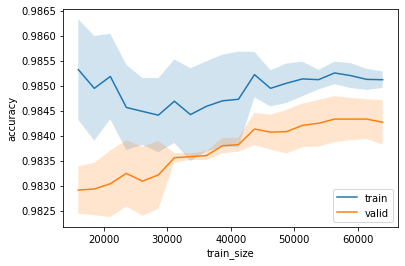

In [94]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

Как мы видим на графике с ростом размера выборки увеличивается качество предсказания, но лишь до определенного момента. Дальнейшее увеличение размера выборки кажется бессмысленным.

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.